In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
def get_text():
  path = tf.keras.utils.get_file('nietzsche.txt',
                               origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt') 
  text = open(path).read().lower()
  return text

In [3]:
text_data = get_text()
print("Character length: {0}".format(len(text_data)))

Character length: 600893


In [4]:
print(text_data[:100])

preface


supposing that truth is a woman--what then? is there not ground
for suspecting that all ph


In [5]:
def preprocess_split(text, max_len, step):
  sentences, next_char = [], []
  for i in range(0, len(text) - max_len, step):
    sentences.append(text[i: i + max_len])
    next_char.append(text[i + max_len])
  char_lst = sorted(list(set(text)))
  char_dict = {char: char_lst.index(char) for char in char_lst}
  X = np.zeros((len(sentences), max_len, len(char_lst)), dtype=bool)
  y = np.zeros((len(next_char), len(char_lst)), dtype=bool)
  for i, sentence in enumerate(sentences):
    for j, char in enumerate(sentence):
      X[i, j, char_dict[char]] = 1
    y[i, char_dict[next_char[i]]] = 1
  return X, y, char_dict

In [6]:
max_len = 60
step = 3
X, y, char_dict = preprocess_split(text_data, max_len, step)
vocab_size = len(char_dict)
print("Number of sequences: {0}\nNumber of unique characters: {1}".format(len(X), vocab_size))

Number of sequences: 200278
Number of unique characters: 57


In [7]:
def build_model(max_len, vocab_size):
  inputs = layers.Input(shape=(max_len, vocab_size))
  x = layers.LSTM(128)(inputs)
  output = layers.Dense(vocab_size, activation=tf.nn.softmax)(x)
  model = Model(inputs, output)
  model.compile(optimizer='adam', loss='categorical_crossentropy')
  return model

In [17]:
model = build_model(max_len, vocab_size)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 57)]          0         
                                                                 
 lstm (LSTM)                 (None, 128)               95232     
                                                                 
 dense (Dense)               (None, 57)                7353      
                                                                 
Total params: 102585 (400.72 KB)
Trainable params: 102585 (400.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
X.shape

(200278, 60, 57)

In [18]:
history = model.fit(X, y, epochs=15, batch_size=128)

Epoch 1/15

1565/1565 [==============================] - 158s 100ms/step - loss: 2.5336
Epoch 2/15
1565/1565 [==============================] - 114s 73ms/step - loss: 2.1776
Epoch 3/15
1565/1565 [==============================] - 171s 109ms/step - loss: 2.0530
Epoch 4/15
1565/1565 [==============================] - 172s 110ms/step - loss: 1.9590
Epoch 5/15
1565/1565 [==============================] - 168s 108ms/step - loss: 1.8833
Epoch 6/15
1565/1565 [==============================] - 172s 110ms/step - loss: 1.8241
Epoch 7/15
1565/1565 [==============================] - 3378s 2s/step - loss: 1.7751
Epoch 8/15
1565/1565 [==============================] - 2911s 2s/step - loss: 1.7326
Epoch 9/15
1565/1565 [==============================] - 220s 140ms/step - loss: 1.6964
Epoch 10/15
1565/1565 [==============================] - 367s 235ms/step - loss: 1.6639
Epoch 11/15
1565/1565 [==============================] - 195s 125ms/step - loss: 1.6356
Epoch 12/15
1565/1565 [======================

In [20]:
model = model.save('model.h5')

c:\Users\mukun\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
model = load_model('model.h5')

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 57)]          0         
                                                                 
 lstm (LSTM)                 (None, 128)               95232     
                                                                 
 dense (Dense)               (None, 57)                7353      
                                                                 
Total params: 102585 (400.72 KB)
Trainable params: 102585 (400.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
def plot_learning_curve(history):
  loss = history.history['loss']
  epochs = [i for i, _ in enumerate(loss)]
  plt.scatter(epochs, loss, color='skyblue')
  plt.xlabel('Epochs'); plt.ylabel('Cross Entropy Loss')
  plt.show()

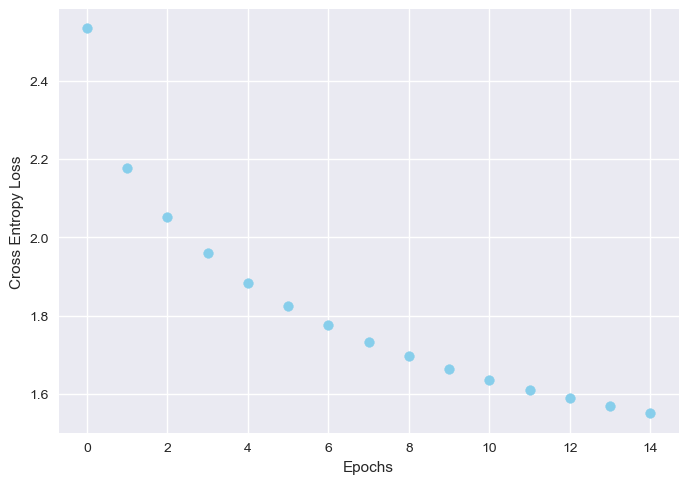

In [21]:
plot_learning_curve(history)

In [22]:
def random_predict(prediction, temperature):
  prediction = np.asarray(prediction).astype('float64')
  log_pred = np.log(prediction) / temperature
  exp_pred = np.exp(log_pred)
  final_pred = exp_pred / np.sum(exp_pred)
  random_pred = np.random.multinomial(1, final_pred)
  return random_pred

In [23]:
def generate_text(model, data, iter_num, seed, char_dict, temperature=1, max_len=60):
  entire_text = list(data[seed])
  for i in range(iter_num):
    prediction = random_predict(model.predict([[entire_text[i: i + max_len]]])[0], temperature)
    entire_text.append(prediction)
  reverse_char_dict = {value: key for key, value in char_dict.items()}
  generated_text = ''
  for char_vec in entire_text:
    index = np.argmax(char_vec)
    generated_text += reverse_char_dict[index]
  return generated_text

In [24]:
def vary_temperature(temp_lst, model, data, iter_num, seed, char_dict):
  for temperature in temp_lst:
    print("Generated text at temperature {0}:\n{1}\n\n".format(temperature, generate_text(model, data, iter_num, seed, char_dict, temperature)))

In [25]:
vary_temperature([0.3, 0.6, 0.9, 1.2], model, X, 1000, 10, char_dict)

ValueError: in user code:

    File "c:\Users\mukun\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\mukun\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mukun\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\mukun\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "c:\Users\mukun\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\mukun\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 1 input(s), but it received 60 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:4' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:6' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:7' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:9' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:10' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:11' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:12' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:13' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:14' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:15' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:16' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:17' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:18' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:19' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:20' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:21' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:22' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:23' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:24' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:25' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:26' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:27' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:28' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:29' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:30' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:31' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:32' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:33' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:34' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:35' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:36' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:37' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:38' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:39' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:40' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:41' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:42' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:43' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:44' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:45' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:46' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:47' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:48' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:49' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:50' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:51' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:52' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:53' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:54' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:55' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:56' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:57' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:58' shape=(None,) dtype=bool>, <tf.Tensor 'IteratorGetNext:59' shape=(None,) dtype=bool>]
